Let's define first our model.

In [159]:
import gc
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm




from keras.callbacks import History, EarlyStopping
from matplotlib.collections import QuadMesh
from pandas import DataFrame
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


target_size = 128

def build_model( ):
    input_tensor = Input(shape=(target_size, target_size, 1))
    
    x = tf.keras.layers.Conv2D(filters=32,  kernel_size=3, input_shape=(target_size, target_size, 1))(
        input_tensor)

    x = tf.nn.relu(x)

    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=x.shape)(
        x)
    x = tf.nn.relu(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=x.shape)(
        x)

    x = tf.nn.relu(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=x.shape)(
        x)

    x = tf.nn.relu(x)
    

    x = tf.keras.layers.MaxPooling2D(strides = 2, pool_size=(2,2),  padding = 'same', input_shape=x.shape)(
        x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, input_shape=x.shape)(
        x)

    x = tf.nn.relu(x)

    x = tf.keras.layers.MaxPooling2D(strides = 2, pool_size=(2,2),  padding = 'same', input_shape=x.shape)(
        x)
    
   

    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, input_shape=x.shape)(
        x)
    x = tf.nn.relu(x)


    
    x = tf.keras.layers.MaxPooling2D(strides = 2, pool_size=(2,2),  padding = 'same', input_shape=x.shape)(
       x)
    
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, input_shape=x.shape)(
        x)
    x = tf.nn.relu(x)


    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, input_shape=x.shape)(
        x)
    x = tf.nn.relu(x)


    
    
    x = tf.keras.layers.Flatten()(x)
    x = Dropout(0.9)(x)
    x = Dense(60, kernel_regularizer=tf.keras.regularizers.l1_l2(1e-5, 1e-4))(x)
    x = tf.nn.relu(x)
    output_tensor = Dense(15, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    
    
    return model
    
from tensorflow.keras.optimizers import Adam

history = History()




model = build_model()
model.compile(optimizer=Adam(5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 126, 126, 32)      320       
_________________________________________________________________
tf.nn.relu_177 (TFOpLambda)  (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 124, 124, 32)      9248      
_________________________________________________________________
tf.nn.relu_178 (TFOpLambda)  (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 122, 122, 64)      18496     
_________________________________________________________________
tf.nn.relu_179 (TFOpLambda)  (None, 122, 122, 64)      0  

We define a crop generator to do some data augmentation

In [161]:
# https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 1
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)



We import our data.

Found 3583 images belonging to 15 classes.
Found 443 images belonging to 15 classes.
Found 459 images belonging to 15 classes.


[]

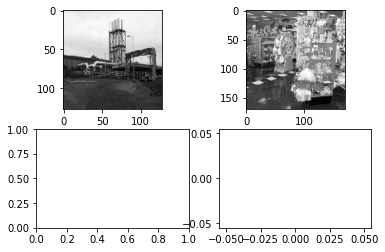

In [162]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

batchSize = 128

# Load the train data and test data

dataDirectory = '/kaggle/input/15scene/dataset' #replace by the directory of your images

train_data_dir = dataDirectory + "/train"
val_data_dir = dataDirectory + "/val"
test_data_dir = dataDirectory + "/test"

datagen = ImageDataGenerator()
aug_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip = True)

train_gen_uncrop = aug_datagen.flow_from_directory(
train_data_dir,
target_size=(170, 170),
batch_size=batchSize,
color_mode='grayscale',
class_mode='categorical')

train_gen = crop_generator(train_gen_uncrop, target_size)

val_gen = aug_datagen.flow_from_directory(
val_data_dir,
target_size=(target_size, target_size),
batch_size=batchSize,
color_mode='grayscale',
class_mode='categorical')



test_gen = aug_datagen.flow_from_directory(
test_data_dir,
target_size=(target_size, target_size),
batch_size=batchSize,
color_mode='grayscale',
class_mode='categorical')




X, y = next(train_gen)
X_uncrop, y_uncrop = train_gen_uncrop.next()

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X[0],cmap='gray')
axarr[0,1].imshow(X_uncrop[0],cmap='gray')

plt.plot()



Now, we train our model with the training data.

In [163]:
nb_epochs = 150
    
model.fit(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch = train_gen_uncrop.samples // batchSize,
        verbose=1,
        callbacks= [history],
        epochs = nb_epochs)
    

model.save("/kaggle/working/scratch_scene") #replace the address by the one where you want to save the trained model



Epoch 1/150
27/27 [==============================] - 8s 257ms/step - loss: 2.8125 - accuracy: 0.0709 - val_loss: 2.6836 - val_accuracy: 0.1016
Epoch 2/150
27/27 [==============================] - 6s 234ms/step - loss: 2.6221 - accuracy: 0.1580 - val_loss: 2.4267 - val_accuracy: 0.2280
Epoch 3/150
27/27 [==============================] - 6s 226ms/step - loss: 2.4909 - accuracy: 0.1939 - val_loss: 2.3433 - val_accuracy: 0.2573
Epoch 4/150
27/27 [==============================] - 6s 233ms/step - loss: 2.3488 - accuracy: 0.2356 - val_loss: 2.2506 - val_accuracy: 0.2912
Epoch 5/150
27/27 [==============================] - 6s 232ms/step - loss: 2.2801 - accuracy: 0.2541 - val_loss: 2.1667 - val_accuracy: 0.3318
Epoch 6/150
27/27 [==============================] - 6s 238ms/step - loss: 2.1932 - accuracy: 0.3059 - val_loss: 1.9920 - val_accuracy: 0.3770
Epoch 7/150
27/27 [==============================] - 6s 235ms/step - loss: 2.0352 - accuracy: 0.3360 - val_loss: 1.8017 - val_accuracy: 0.4086

We now plot some results of our model : 

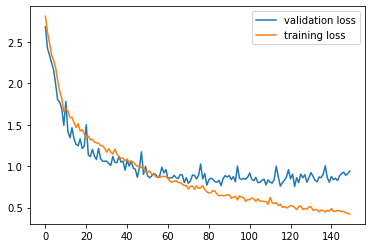

In [164]:
num_epochs = np.arange(nb_epochs)

plt.plot(num_epochs,history.history['val_loss'], label= 'validation loss')
plt.plot(num_epochs, history.history['loss'], label= 'training loss')
plt.legend()
plt.show()

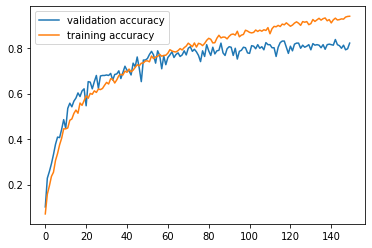

In [165]:
plt.plot(num_epochs,history.history['val_accuracy'], label= 'validation accuracy')
plt.plot(num_epochs, history.history['accuracy'], label= 'training accuracy')
plt.legend()
plt.show()

In [176]:
model.evaluate(
        test_gen,
        steps = 20,
        verbose=1)


20/20 [==============================] - 1s 23ms/step - loss: 1.0786 - accuracy: 0.8039
